In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import copy
import seaborn as sns; sns.set()
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
import gym
env = gym.envs.make("CartPole-v0")

/home/igor/miniconda3/envs/rl2019/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
# import time
# # The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
# obs = env.reset()
# env.render()
# done = False
# while not done:
#     obs, reward, done, _ = env.step(env.action_space.sample())
#     env.render()
#     time.sleep(0.05)
# env.close()  # Close the environment or you will have a lot of render screens soon

In [4]:
class QNetwork(nn.Module):
    
    def __init__(self, num_s, num_a, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(num_s, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_a)

    def forward(self, x):
        # YOUR CODE HERE
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [5]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = QNetwork(num_hidden=num_hidden, num_a=2, num_s=4)

torch.manual_seed(1234)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(model(x).numpy(), test_model(x).numpy())

In [6]:
class ReplayMemory:
    
    def __init__(self, capacity, useTrick=True):
        self.capacity = capacity
        self.memory = []
        # useTrick defines whether or not experience replay is really used
        self.useTrick = useTrick

    def push(self, transition):
        # YOUR CODE HERE
        if len(self.memory) >= self.capacity:
            # if memory is full we remove the last value and add the new value at beginning
            # use a deque next time
            self.memory.insert(0, transition)
            self.memory = self.memory[:-1]
        else:
            self.memory.insert(0, transition)

    def sample(self, batch_size):
        
        if self.useTrick:
            # random batch
            return random.sample(self.memory, batch_size)
        else:
            # latest batch_size memories
            return self.memory[-batch_size:]

    def __len__(self):
        return len(self.memory)
    
memory = ReplayMemory(2)
memory.push(2)
memory.push(3)
memory.push(4)
assert memory.memory[0] == 4
assert memory.memory[1] == 3

In [7]:
def get_epsilon(it):
    return max(1 - 0.00095*it, 0.05)

In [8]:
def select_action(model, state, epsilon):
    # YOUR CODE HERE
    _rand = random.random()
    state = torch.from_numpy(state).float()
    if _rand < epsilon:
        
        #TODO this is now hardcoded to return either 0 or 1, but might be different for different envs.
        
        # random move left (0) or right (1)
        return torch.randint(2, (1,)).item()
    else:
        with torch.no_grad():
            return torch.argmax(model(state)).item()


In [9]:
s = env.reset()
a = select_action(model, s, 0.05)
assert not torch.is_tensor(a)
print (a)


1


In [10]:
def compute_q_val(model, state, action):
    # YOUR CODE HERE
    # https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms
    # model(state) contains estimated q values from the model
    # action contains the action chosen by the model at that point
    return model(state).gather(1, action.unsqueeze(1))
    
    
class targetComputer():
    def __init__(self, target_network_steps=0):
        self.UPDATE_STEPS = target_network_steps
        self.target_network_steps = self.UPDATE_STEPS
        
    def compute_target(self, model, reward, next_state, done, discount_factor):
        # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
        # YOUR CODE HERE

        # only update self.model to given model is target_network_steps = 0
        if not hasattr(self, 'model'):
            self.model = copy.deepcopy(model)
        elif self.target_network_steps == 0:
            
            self.model = model
            self.target_network_steps = self.UPDATE_STEPS
        
        max_Q_prime = torch.zeros(next_state.shape[0])  # batch size

        # create mask of non-done states
        non_final_mask = torch.tensor(tuple(map(lambda s: s != 1, done)), dtype=torch.bool)

        # when state is not done we add discount_factor * max() else 0
        max_Q_prime[non_final_mask] = torch.max(self.model(next_state[non_final_mask]), 1).values
        
        self.target_network_steps -= 1

        return (reward + discount_factor * max_Q_prime).unsqueeze(1)

def train(model, memory, optimizer, batch_size, discount_factor, TargetComputer):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = TargetComputer.compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to t Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [11]:
def run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate, TargetComputer):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    losses = []
    
    
#     for i in tqdm(range(num_episodes)): <-- this gets a bit annoying when doing more runs
    for i in range(num_episodes):
        # YOUR CODE HERE
        # following algo from here: https://drive.google.com/file/d/0BxXI_RttTZAhVUhpbDhiSUFFNjg/view
        
        episode_duration = 0
        s = env.reset()
        while True:
            # a = select_action(model, s, -10); # print('Careful: running with all random action selection') # epsilon-greedy select action
            a = select_action(model, s, get_epsilon(global_steps)) # epsilon-greedy select action
            s_next, r, done, _ = env.step(a)  # execute action a_t in emulator
            episode_duration += 1
                
            memory.push((s, a, r, s_next, done))  # store transition in D
            global_steps += 1
            s = s_next
            if done:
                break
            loss = train(model, memory, optimizer, batch_size, discount_factor, TargetComputer)
            losses.append(loss)
        episode_durations.append(episode_duration)
#     plt.plot(losses[900:])
    
    return episode_durations

In [12]:
# Let's run it!


def get_state_number(env):
    if isinstance(env.env.observation_space, gym.spaces.box.Box):
        nS = env.env.observation_space.shape[0]
    elif isinstance(env.env.observation_space, gym.spaces.discrete.Discrete):
        nS = env.env.observation_space.n
    else:
        print("Encountered unknown class type in state: {}. Exiting code execution".format(type(item[1])))
        exit()    
    return nS

def get_action_number(env):
    

    if isinstance(env.env.action_space, gym.spaces.box.Box):
        nA = env.env.action_space.shape[0]
    elif isinstance(env.env.action_space, gym.spaces.discrete.Discrete):
        nA = env.env.action_space.n
    else:
        print("Encountered unknown class type in action: {}. Exiting code execution".format(type(item[1])))
        exit()    
        
    env.env.observation_space
    return nA

def run_experiment(hyperparams):
    
    num_episodes = hyperparams['num_episodes']
    batch_size = hyperparams['batch_size']
    discount_factor = hyperparams['discount_factor']
    learn_rate = hyperparams['learn_rate']
    memory = hyperparams['memory']
    num_hidden = hyperparams['num_hidden']
    seed = hyperparams['seed']
    target_network_steps = hyperparams['target_network_steps']
    env = hyperparams['env']

    # We will seed the algorithm (before initializing QNetwork!) for reproducability
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)
    
    nA = get_action_number(env)
    nS = get_state_number(env)

    model = QNetwork(num_hidden=num_hidden, num_a=nA, num_s=nS)

    TargetComputer = targetComputer(target_network_steps=target_network_steps)

    episode_durations = run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate, TargetComputer)

    # And see the results
    return episode_durations

In [16]:
import pickle
mountainEnv = gym.envs.make("MountainCar-v0")
pendulumEnv = gym.envs.make("Pendulum-v0")
acrobotEnv = gym.envs.make("Acrobot-v1")
cartPoleEnv = gym.envs.make("CartPole-v1")
mountainCarContEnv = gym.envs.make("MountainCarContinuous-v0")

envs = [mountainEnv, acrobotEnv, cartPoleEnv]
#mountainEnv works
#pendulumEnv doesn't work..
#acrobotEnv works
#cartPoelEnv works
#mountainCarContEnv doesn't work..

# both don't work because they have a continuous action space, I think.

# currently, cartPoleEnv is nicest. It divergew with useTrick = False, and converges with useTrick=True


hyperparams = {
    'env':                  cartPoleEnv,  # the environment
    'num_episodes':         100,   #100  
    'batch_size':           64,
    'discount_factor':      0.8,   #0.99 completely diverges
    'learn_rate':           1e-3,
    'memory':               ReplayMemory(10000, useTrick=True), # set useTrick=False for no memory replay
    'num_hidden':           128,
    'seed':                 10,  # This is not randomly chosen <-- from TAs
    'target_network_steps': 1   # If set to 1, (I THINK) this means we update the target network every step, thus we actually do not use a target network
}


# We can e.g. do grid-search here.
# for env in envs:
#     hyperparams['env'] = env
#     run_experiment(hyperparams)

smooth_c = 10
repeats = 20

results={}

for replay in [True, False]:
    
    hyperparams['memory'] = ReplayMemory(10000, useTrick=replay)
    
#     for index, steps in enumerate([1, 50, 200, 500]):
    for steps in [1, 50, 100, 200, 500]:
        
        results['episode'] = []
        
        hyperparams['target_network_steps'] = steps
        
        key = 'replay' if replay else 'no-replay'
        
        identifier =  '{}_steps{}_repeats{}'.format(key, steps)
        print('Running {}'.format(identifier))
        results[identifier] = []
        
        for repeat in range(repeats):
            results[identifier].extend(run_experiment(hyperparams))
            results['episode'].extend(list(range(hyperparams['num_episodes'])))
            
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)
    
# def smooth(x, N):
# cumsum = np.cumsum(np.insert(x, 0, 0)) 
# return (cumsum[N:] - cumsum[:-N]) / float(N)
# plt.plot(smooth(episode_durations, smooth_c), label="{}".format(steps))
# plt.title('Episode durations per episode {} using Experience Replay (smoothed over {} episodes)'.format('' if replay else 'not', smooth_c))
# plt.legend()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


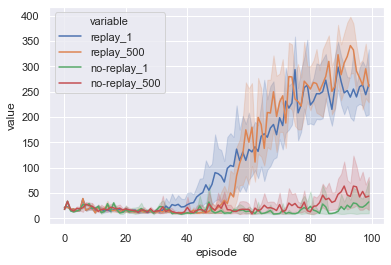

In [143]:
# can be used to display dataframe in ipython notebook
from IPython.display import display, HTML

test_df = pd.DataFrame(results)

# e.g. display(test_df)


# pd.melt is required to get several plots in one graph, got it from 
# https://stackoverflow.com/questions/52308749/how-do-i-create-a-multiline-plot-using-seaborn
# 2nd answer

sns.lineplot(x='episode', y='value', hue='variable', 
             data=pd.melt(test_df, ['episode']), ci=95)


In [17]:
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

In [19]:
results.keys()

dict_keys(['episode', 'replay_steps1_repeats20', 'replay_steps50_repeats20', 'replay_steps100_repeats20', 'replay_steps200_repeats20', 'replay_steps500_repeats20', 'no-replay_steps1_repeats20', 'no-replay_steps50_repeats20', 'no-replay_steps100_repeats20', 'no-replay_steps200_repeats20', 'no-replay_steps500_repeats20'])

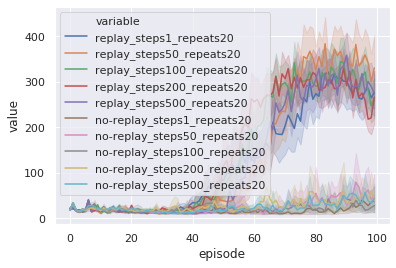

In [20]:
test_df = pd.DataFrame(results)

sns.lineplot(x='episode', y='value', hue='variable', 
             data=pd.melt(test_df, ['episode']), ci=95)